## installations

In [1]:
pip install tensorflow


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\HP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Data preprocessing

In [2]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\HP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Set the path to your dataset
dataset_path = r"C:\Users\HP\Desktop\epic\data"  # Change this to your actual dataset path
image_size = (64, 64)  # Resize images for faster processing

def load_data(dataset_path):
    image_pairs = []
    labels = []
    rollnos = sorted(os.listdir(dataset_path))

    # Loop over each student's directory
    for rollno in rollnos:
        student_path = os.path.join(dataset_path, rollno)
        images = sorted(os.listdir(student_path))

        # Create positive pairs for each student
        for i in range(len(images)):
            for j in range(i + 1, len(images)):
                img1 = cv2.imread(os.path.join(student_path, images[i]))
                img2 = cv2.imread(os.path.join(student_path, images[j]))
                if img1 is not None and img2 is not None:
                    img1 = cv2.resize(img1, image_size)
                    img2 = cv2.resize(img2, image_size)
                    image_pairs.append([img1, img2])
                    labels.append(1)  # Same person

        # Create negative pairs between different students
        for other_rollno in rollnos:
            if other_rollno != rollno:
                other_student_path = os.path.join(dataset_path, other_rollno)
                if os.listdir(other_student_path):
                    img1 = cv2.imread(os.path.join(student_path, images[0]))
                    img2 = cv2.imread(os.path.join(other_student_path, os.listdir(other_student_path)[0]))
                    if img1 is not None and img2 is not None:
                        img1 = cv2.resize(img1, image_size)
                        img2 = cv2.resize(img2, image_size)
                        image_pairs.append([img1, img2])
                        labels.append(0)  # Different person

    # Convert to numpy arrays and normalize images
    image_pairs = np.array(image_pairs) / 255.0
    labels = np.array(labels)
    return image_pairs, labels

# Load data
image_pairs, labels = load_data(dataset_path)

print(f"completed processing of {len(image_pairs)}")

completed processing of 9856


## Dividing into Testing and Training

In [4]:
#---------------------xxxxxxxxxxxxxxxxxxxxxxxxxx---------------------Shuffled----------------------xxxxxxxxxxxxxxxxxxxx---------------------

# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split

# # Shuffle the dataset before splitting
# image_pairs, labels = shuffle(image_pairs, labels, random_state=42)

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(image_pairs, labels, test_size=0.2, random_state=42)


#---------------------xxxxxxxxxxxxxxxxxxxxxxxxxx---------------------non-Shuffled----------------------xxxxxxxxxxxxxxxxxxxx---------------------

X_train, X_test, y_train, y_test = train_test_split(image_pairs, labels, test_size=0.2, random_state=42)

# printing lengths
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 7884
Testing set size: 1972


## Model Building

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam

def create_siamese_model(input_shape):
    # Define the CNN subnetwork for feature extraction
    input = Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu')(input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(64, activation='relu')(x)
    return Model(inputs=input, outputs=output)

# Define input shape based on preprocessed image size
input_shape = (64, 64, 3)
siamese_base = create_siamese_model(input_shape)

# Siamese Network with two inputs (image pairs)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Generate feature representations for both images
output_a = siamese_base(input_a)
output_b = siamese_base(input_b)

# Compute L1 distance between features
L1_distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([output_a, output_b])
similarity_score = layers.Dense(1, activation="sigmoid")(L1_distance)

# Complete Siamese model
siamese_model = Model(inputs=[input_a, input_b], outputs=similarity_score)
siamese_model.compile(optimizer=Adam(0.0001), loss="binary_crossentropy", metrics=["accuracy"])

siamese_model.save('siamese.h5')

## Model Training

In [6]:
# Train the Siamese model
history = siamese_model.fit(
    [X_train[:, 0], X_train[:, 1]],  # First and second images in the pair
    y_train,
    epochs=25,
    batch_size=32,
    validation_data=([X_test[:, 0], X_test[:, 1]], y_test)
)


Epoch 1/25


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_8', 'keras_tensor_9']. Received: the structure of inputs=('*', '*')
  warnings.warn(


247/247 ━━━━━━━━━━━━━━━━━━━━ 75s 290ms/step - accuracy: 0.9770 - loss: 0.2716 - val_accuracy: 0.9949 - val_loss: 0.0660
Epoch 2/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 72s 292ms/step - accuracy: 0.9949 - loss: 0.0469 - val_accuracy: 0.9959 - val_loss: 0.0292
Epoch 3/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 70s 285ms/step - accuracy: 0.9953 - loss: 0.0217 - val_accuracy: 0.9985 - val_loss: 0.0092
Epoch 4/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 73s 294ms/step - accuracy: 0.9989 - loss: 0.0068 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 5/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 77s 313ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 6/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 80s 323ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9949 - val_loss: 0.0109
Epoch 7/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 71s 289ms/step - accuracy: 0.9994 - loss: 0.0035 - val_accuracy: 0.9985 - val_loss: 0.0076
Epoch 8/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 75s 261ms/step - accuracy: 1.0000 - loss: 0.0036 - val

## Model Testing

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_8', 'keras_tensor_9']. Received: the structure of inputs=('*', '*')
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step


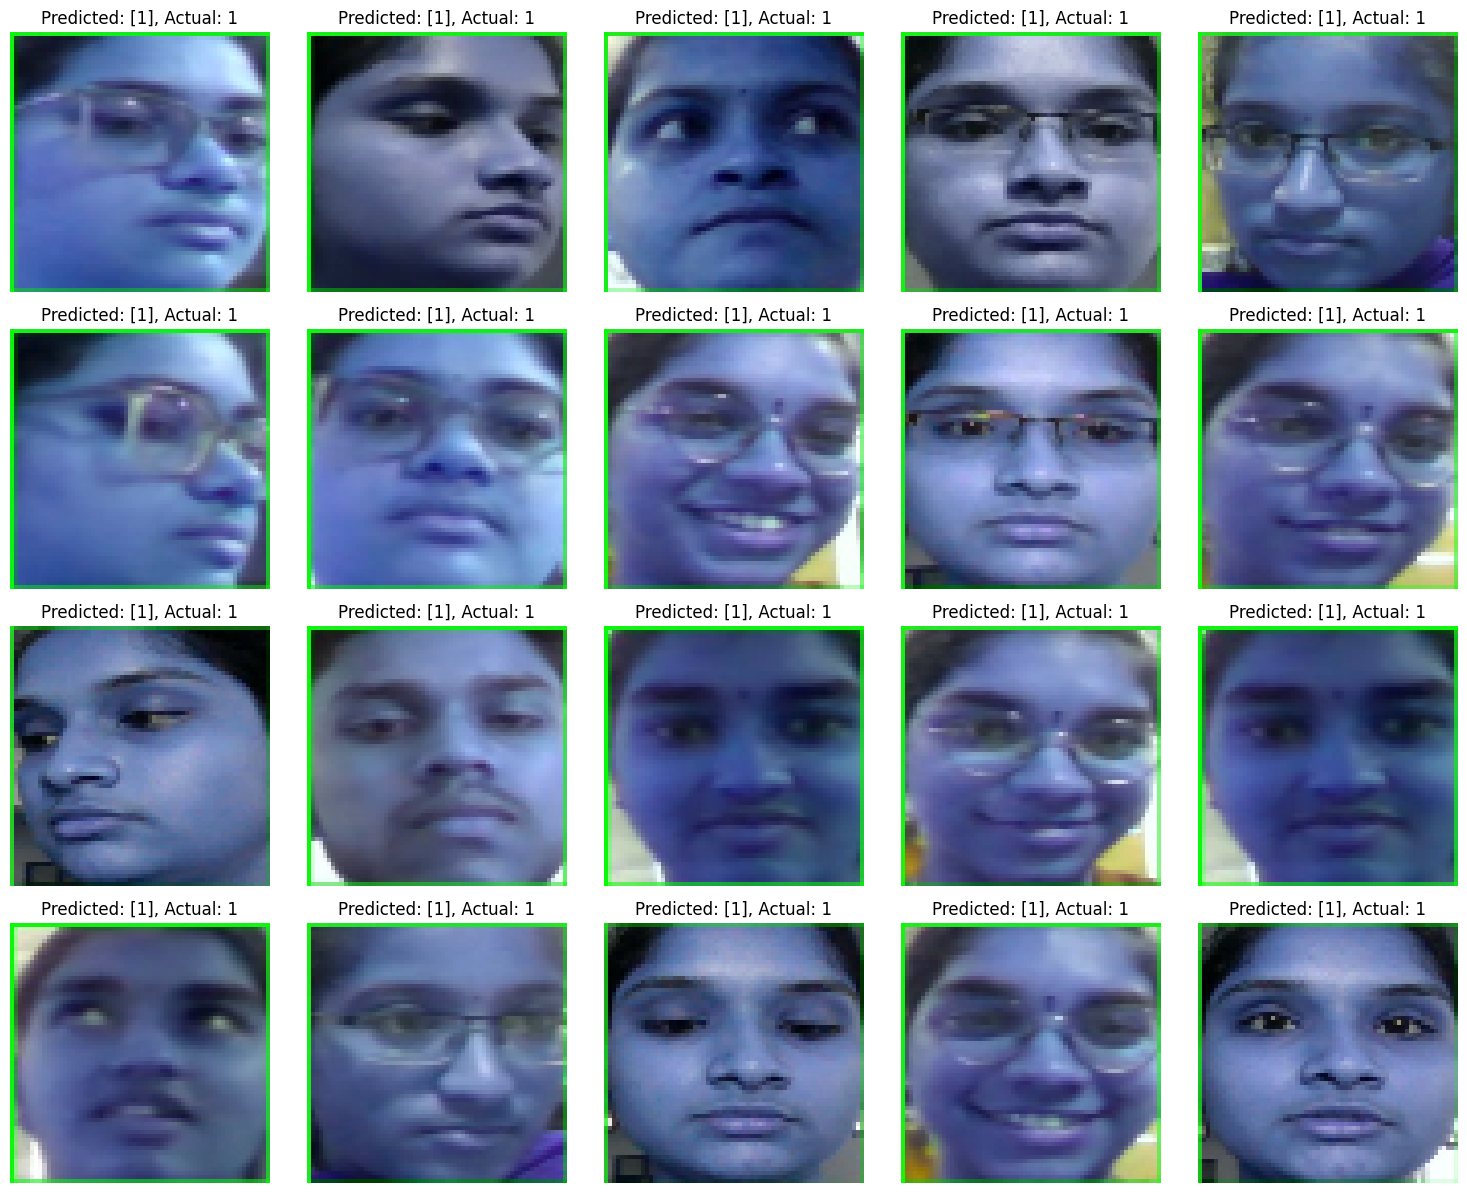

Accuracy: 98.99%
Error: 1.01%


In [7]:
import matplotlib.pyplot as plt
import numpy as np


X_test_image1 = X_test[:, 0]  # The first image of each pair
X_test_image2 = X_test[:, 1]  # The second image of each pair
# Assuming you have a function to get predictions from the Siamese network
# For a pair of images, the output is a similarity score (e.g., a value between 0 and 1)
predictions = siamese_model.predict([X_test_image1, X_test_image2])  # Siamese model takes pairs of images

# Convert similarity scores to binary labels based on a threshold (e.g., 0.5)
predicted_labels = (predictions > 0.5).astype(int)
true_labels = y_test  # Actual labels (0 or 1)

# Display a few image pairs with their predicted and actual labels
num_images = 20  # Number of pairs to display
plt.figure(figsize=(15, 15))

for i in range(num_images):
    plt.subplot(5, 5, i + 1)
    # Display the first image in the pair
    plt.imshow(X_test_image1[i], cmap='gray')
    plt.title(f"Predicted: {predicted_labels[i]}, Actual: {true_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.savefig('siamese_tested.png')
plt.show()

# Calculate accuracy and error for Siamese model
accuracy = np.mean(predicted_labels == true_labels)
error = 1 - accuracy

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Error: {error * 100:.2f}%")


## Graphs plotting

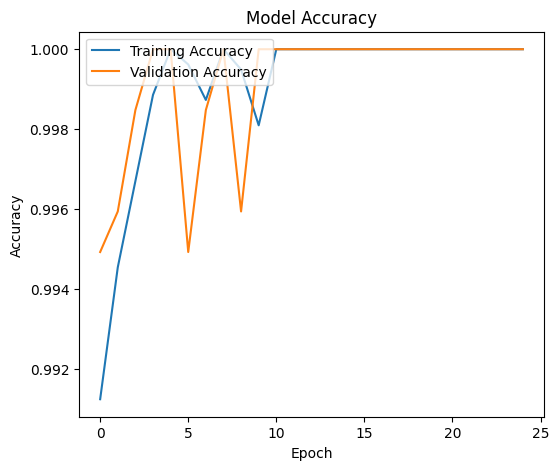

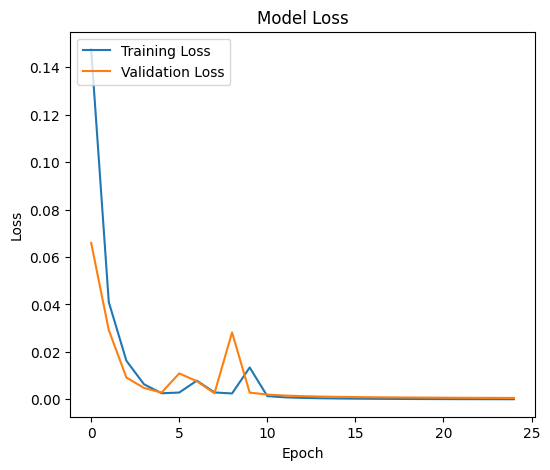

In [8]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.savefig('siamese_accuracy_plot.png')  # Save accuracy plot
plt.show()

# Loss plot
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.savefig('siamese_loss_plot.png')  # Save loss plot
plt.show()


## Confusion matrix

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step


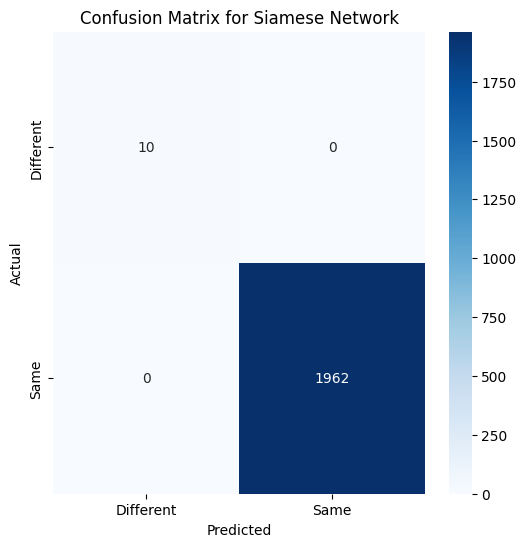

Confusion Matrix:
[[  10    0]
 [   0 1962]]


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have a Siamese model and the following:
# predictions are the output similarity scores for image pairs
# X_test_image1 and X_test_image2 are the test image pairs
# y_test is the true label (1 for same class, 0 for different class)

# Get the predictions for the test pairs (output is a similarity score)
predictions = siamese_model.predict([X_test_image1, X_test_image2])

# Convert similarity scores to binary labels (1 for same class, 0 for different class)
predicted_labels = (predictions > 0.5).astype(int)

# True labels (0 or 1), where 1 means same class, and 0 means different class
true_labels = y_test

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Different', 'Same'], yticklabels=['Different', 'Same'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Siamese Network')
plt.savefig('siamese_matrix.png')
plt.show()

# Optionally, print the confusion matrix for numerical output
print("Confusion Matrix:")
print(cm)


## performance metrics

In [10]:
pip install scikit-learn matplotlib


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\HP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [11]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load the saved Siamese model


# Assuming you have X_test_image1, X_test_image2 (test pairs) and y_test (true labels)
# predictions are the output similarity scores for image pairs
predictions = siamese_model.predict([X_test_image1, X_test_image2])

# Convert similarity scores to binary labels (1 for similar, 0 for dissimilar)
predicted_labels = (predictions > 0.5).astype(int)

# True labels (0 or 1), where 1 means same class, and 0 means different class
true_labels = y_test

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate precision
precision = precision_score(true_labels, predicted_labels)
print(f"Precision: {precision * 100:.2f}%")

# Calculate recall
recall = recall_score(true_labels, predicted_labels)
print(f"Recall: {recall * 100:.2f}%")

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels)
print(f"F1 Score: {f1 * 100:.2f}%")

# Calculate AUC (Area Under the Curve) for ROC
roc_auc = roc_auc_score(true_labels, predictions)
print(f"AUC (ROC): {roc_auc:.2f}")

# # Optionally, plot the ROC curve
# fpr, tpr, _ = roc_curve(true_labels, predictions)
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC)')
# plt.legend(loc='lower right')
# plt.show()


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%
AUC (ROC): 1.00


## Testing through a image

In [ ]:
# # Example of prediction
# def predict_similarity(img1_path, img2_path):
#     img1 = cv2.imread(img1_path)
#     img2 = cv2.imread(img2_path)
#     img1 = cv2.resize(img1, image_size) / 255.0
#     img2 = cv2.resize(img2, image_size) / 255.0
#     prediction = siamese_model.predict([np.expand_dims(img1, axis=0), np.expand_dims(img2, axis=0)])
#     return prediction[0][0]

# # Example usage
# print("Similarity Score:", predict_similarity("path/to/image1.jpg", "path/to/image2.jpg"))


## Testing through live input

In [ ]:
import cv2
import numpy as np

# Define a function to capture frames from webcam, process, and display results
def recognize_live_faces(model, dataset_path, threshold=0.5):
    # Initialize the webcam
    cap = cv2.VideoCapture(0)
    image_size = (64, 64)  # This should match the model input size

    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to grayscale for face detection (or use a color version if needed)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Use OpenCV's Haar Cascade to detect faces (or any other face detector)
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(gray_frame, 1.1, 4)

        # Loop through detected faces
        for (x, y, w, h) in faces:
            # Extract face region
            face_img = frame[y:y+h, x:x+w]
            face_img_resized = cv2.resize(face_img, image_size) / 255.0

            best_match_rollno = None
            best_score = 0

            # Loop through each roll number folder to compare with images
            for rollno in sorted(os.listdir(dataset_path)):
                rollno_path = os.path.join(dataset_path, rollno)
                for img_name in os.listdir(rollno_path):
                    # Load each image in the roll number folder and preprocess it
                    img_path = os.path.join(rollno_path, img_name)
                    dataset_img = cv2.imread(img_path)
                    if dataset_img is not None:
                        dataset_img_resized = cv2.resize(dataset_img, image_size) / 255.0
                        # Predict similarity score
                        prediction = model.predict([np.expand_dims(face_img_resized, axis=0), 
                                                    np.expand_dims(dataset_img_resized, axis=0)])
                        score = prediction[0][0]
                        
                        # Update best match if score is higher than previous
                        if score > best_score and score >= threshold:
                            best_score = score
                            best_match_rollno = rollno

            # Display the roll number and similarity score if a match was found
            if best_match_rollno:
                text = f"Roll No: {best_match_rollno} | Score: {best_score:.2f}"
                color = (0, 255, 0) if best_score >= threshold else (0, 0, 255)
                cv2.putText(frame, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
                cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            else:
                cv2.putText(frame, "Unknown", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2)

        # Display the frame with recognition information
        cv2.imshow('Face Recognition', frame)

        # Break loop with 'q' key
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the webcam and close windows
    cap.release()
    cv2.destroyAllWindows()

# Run the real-time recognition
recognize_live_faces(siamese_model, dataset_path=r"C:\Users\HP\Desktop\epic\data", threshold=0.5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

## Attendance logging

In [15]:
import os
import cv2
import numpy as np
import pandas as pd
from datetime import datetime
from tensorflow.keras.preprocessing.image import img_to_array
from mtcnn import MTCNN
from tensorflow.keras.models import load_model

# Function to load and preprocess images
def load_images(data_path):
    images = []
    labels = []
    label_map = {}
    label_counter = 0

    for label_name in os.listdir(data_path):
        folder_path = os.path.join(data_path, label_name)
        if os.path.isdir(folder_path):
            # Assign label IDs
            if label_name not in label_map:
                label_map[label_name] = label_counter
                label_counter += 1

            for file_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, file_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (64, 64))  # Resize to 64x64 pixels
                images.append(img)
                labels.append(label_map[label_name])

    images = np.array(images) / 255.0  # Normalize pixel values
    labels = np.array(labels)
    return images, labels, label_map

# Function to capture an image using the webcam
def capture_class_image(camera_index=0):
    """
    Captures an image from the webcam.
    
    Parameters:
    - camera_index: The index of the camera (default is 0 for the first camera).
    
    Returns:
    - captured_img: The captured image from the webcam.
    """
    cap = cv2.VideoCapture(camera_index)  # Open the camera
    ret, frame = cap.read()  # Capture a frame
    if not ret:
        print("Failed to capture image.")
        return None
    cap.release()  # Release the camera after capturing the image
    return frame

# Function to mark attendance based on face recognition
def mark_attendance(siamese_model, excel_file_path, attendance_times, camera_index=0):
    """
    Marks attendance for the students based on the trained model and class image.
    
    Parameters:
    - model: The trained face recognition model.
    - excel_file_path: Path to the Excel file containing student roll numbers and attendance data.
    - attendance_times: A list of times when attendance needs to be taken.
    - camera_index: The index of the camera to capture the class image (default is 0).
    """
    
    # Get the current time
    current_time = datetime.now().strftime('%H:%M')
    # Get the current date
    date = datetime.now().strftime('%Y-%m-%d')
    
    # If current time matches one of the times in attendance_times, take attendance
    if current_time in attendance_times:
        print(f"Taking attendance at {current_time}...")

        # Capture the class image using the webcam
        class_img = capture_class_image(camera_index)
        if class_img is None:
            print("No image captured.")
            return

        # Detect faces using MTCNN
        detector = MTCNN()
        faces = detector.detect_faces(class_img)
        
        if len(faces) == 0:
            print("No faces detected.")
            return

        # Preprocess faces for recognition (like in load_images function)
        embeddings = []
        for face in faces:
            x, y, width, height = face['box']
            face_img = class_img[y:y+height, x:x+width]
            face_img = cv2.resize(face_img, (64, 64))  # Resize to 64x64 pixels
            face_img = face_img / 255.0  # Normalize image as in the load_images function
            embeddings.append(face_img)

        embeddings = np.array(embeddings)

        # Predict roll numbers using the trained model
        predictions = siamese_model.predict(embeddings)
        recognized_rollnos = [np.argmax(pred) for pred in predictions]
        print(f"Recognized Roll Numbers: {recognized_rollnos}")

        # Load the Excel file containing the attendance sheet
        df = pd.read_excel(excel_file_path)

        # Add a column for today's date if it doesn't exist
        if date not in df.columns:
            df[date] = "Absent"  # Default to "Absent" for all

        # Mark attendance for the current period (based on current hour)
        period = f"Period{datetime.now().hour}"

        # Add a period column if it doesn't exist
        if period not in df.columns:
            df[period] = "Absent"  # Default to "Absent" for the period

        # Mark attendance based on recognized roll numbers
        for roll_no in df['Roll No']:
            if roll_no in recognized_rollnos:
                df.loc[df['Roll No'] == roll_no, period] = "Present"  # Mark "Present"
            else:
                df.loc[df['Roll No'] == roll_no, period] = "Absent"  # Mark "Absent"

        # Save updated attendance to Excel
        df.to_excel(excel_file_path, index=False)
        print(f"Attendance marked for {date} at {period}")
    else:
        print(f"No attendance needed at {current_time}.")

# Example usage
attendance_times = ["06:31", "06:32", "07:04", "09:59", "13:22", "19:10", "21:34"]  # List of times to take attendance
excel_file_path = r"C:\Users\HP\Desktop\epic\siamese_attendance.xlsx"  # Path to your Excel file

# Load your trained model
# model = load_model(r"C:\Users\HP\Desktop\epic\siamese.h5")  # Replace with your actual model path

# Function call to mark attendance
mark_attendance(siamese_model, excel_file_path, attendance_times)


Taking attendance at 07:04...


ValueError: Layer "functional_1" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(1, 64, 64, 3) dtype=float32>]